# Find the form of an expression by limiting a theoretical expression

In [333]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable

from scipy.integrate import quad
from scipy.optimize import brentq
import numpy as np

In [334]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)

In [335]:
from sympy import *

In [336]:
rp,m,rp,r0 = symbols('r,m,r_+,r_0',real=True)

In [5]:
J = Integral()

TypeError: Integral.__new__() missing 1 required positional argument: 'function'

In [6]:
import sympy as sp

# 변수 정의
rp = sp.Symbol('r_+', positive=True,real=True)
Omega = sp.Symbol('Omega')
K, m = sp.symbols('K m', positive=True,real=True)
omega_p = sp.Symbol('omega_+', real=True)
Omegap, dOmega = sp.symbols('Omega_+ \delta\Omega', real=True)

# 함수 정의
g = sp.Function('g')(Omega)

# 첫 번째 적분
lower1 = omega_p
upper1 = omega_p + Omegap + dOmega
integrand1 = g * sp.sqrt(1 - ((Omega - dOmega - omega_p)**2) / (K**2 * rp**2))
I1 = sp.integrate(integrand1, (Omega, lower1, upper1))

# 두 번째 적분
lower2 = omega_p + Omegap + dOmega
upper2 = sp.oo
integrand2 = g * 1 / (2 * (1 + m**2 * Omega**2))
I2 = sp.integrate(integrand2, (Omega, lower2, upper2))

# 전체 식
expr = I1 - K * rp * m * I2

# 극한 계산: r -> 0+
lim_expr = sp.limit(expr, rp, 0, dir='+')
lim_expr


Limit(-K*m*r_+*Integral(g(Omega)/(Omega**2*m**2 + 1), (Omega, Omega_+ + \delta\Omega + omega_+, oo))/2 + Integral(sqrt(K**2*r_+**2 - Omega**2 + 2*Omega*\delta\Omega + 2*Omega*omega_+ - \delta\Omega**2 - 2*\delta\Omega*omega_+ - omega_+**2)*g(Omega), (Omega, omega_+, Omega_+ + \delta\Omega + omega_+))/(K*r_+), r_+, 0, dir='+')

In [7]:
import numpy as np
from scipy.integrate import quad
from math import sqrt, pi, exp

# Given parameters
K = 6
m = 6
r0 = 0.76

# Very small r_plus approaching 0+
r_plus = 1e-5

# Define omega_c (Domega)
omega_c = 4 * sqrt(K * r_plus) / (pi * sqrt(m) - 0.3056 / sqrt(K * r_plus * m**3))

# Omega_p (same form as omega_c)
Omega_p = omega_c

# Define delta_Omega
numerator = K * (2 * m * r0 + r_plus) * (pi * sqrt(K) * m**2 * sqrt(r_plus) - 0.3056)**3
denominator = 16 * m**(3/2) * (64 * K**2 * m**5 * r_plus**2 + (pi * sqrt(K) * m**2 * sqrt(r_plus) - 0.3056)**2)
delta_Omega = numerator / denominator

# g(Ω) = standard normal PDF
def g(Omega):
    return (1 / sqrt(2 * pi)) * np.exp(-Omega**2 / 2)

# I1 approximation
g_val = g(delta_Omega + omega_c)
I1_approx = g_val * K * r_plus * pi / 2

# I2 integral (numerically)
def integrand(Omega):
    return g(Omega) / (2 * (1 + m**2 * Omega**2))

lower_limit = omega_c + Omega_p + delta_Omega
I2_val, _ = quad(integrand, lower_limit, np.inf)

# Full expression value (divided by r_plus)
limit_val = (I1_approx - K * r_plus * m * I2_val) / r_plus
limit_val


2.922139780661662

In [29]:
r =  0.5
m = 10
omega_p =  4*np.sqrt(K*r/m) - 0.3506 / np.sqrt(K*r*m**3)
Kc2 = 2/np.pi / g(omega_p)

In [30]:
Kc2

17.345833173559125

In [49]:
K = 4
m = 6
# rs = np.linspace(0,1,10000)[1:]
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd


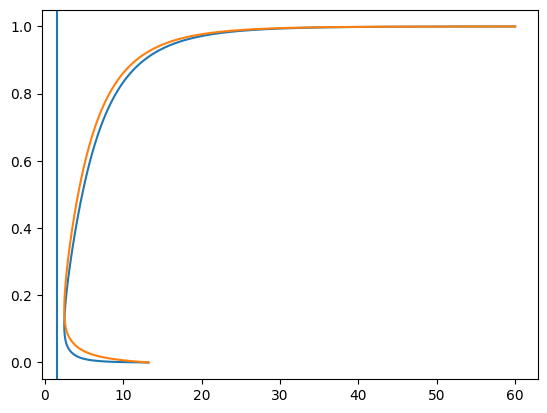

In [58]:
plt.plot(KK,R)
plt.plot(KK,R0)
plt.axvline(2/(np.pi*g(0)))

In [67]:
RP1_u = []
RP1_d = []
RP01_u = []
RP01_d = []
Kc2s = np.nan*np.ones_like(K_u)
K1p = []
for i,(X,K,r,r0,rd,OP) in enumerate(list(zip(Xsu,K_u,R_u,R_0u,R_du,OPS))):
    omega_p =  4*np.sqrt(K*r/m) - 0.3056 / np.sqrt(K*r*m**3)
    Kc2s[i] = 2/(np.pi * g(omega_p))

(0.0, 6.0)

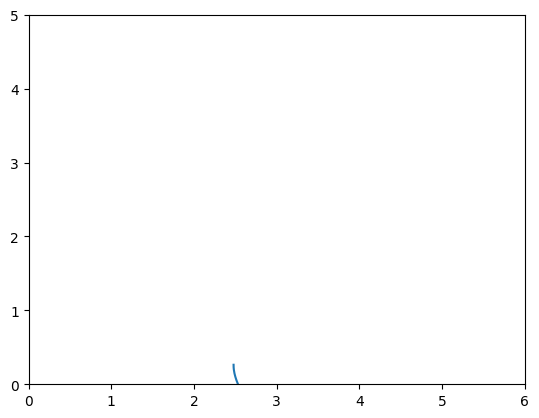

In [65]:
plt.plot(K_u,Kc2s)
plt.ylim(0,5)
plt.xlim(0,6)

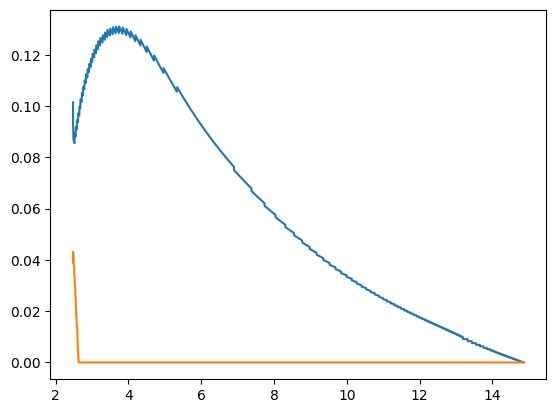

In [69]:
RP1_u = []
RP1_d = []
RP01_u = []
RP01_d = []

K1p = []
for X,K,r,r0,rd,OP in zip(Xsu,K_u,R_u,R_0u,R_du,OPS):
    rs1 = np.logspace(-6,np.log10(0.01),100)
    rps = np.r_[rs1,np.linspace(0.01,(1-r0)/2,100)] 
    omega_pp = X
    RP_ls = np.nan*rps
    RP_ds = np.nan*rps

    for i,rp in enumerate(rps):
        # OPs = K*rp
        a = 1/np.sqrt(K*rp*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        OPs = max(b*K*rp,0)
        
        delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
        RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
        RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    RP = (RP_ls-RP_ds)
    x, = np.where((RP-rps)>=0)
    # plt.plot(rps,RP-rps)
    
    
    try:
        RP1_u.append(rps[x[-1]])
        RP1_d.append(rps[x[0]])
        RP01_u.append(RP_ls[x[-1]])
        RP01_d.append(RP_ls[x[0]])
        K1p.append(K)
    except:pass
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)

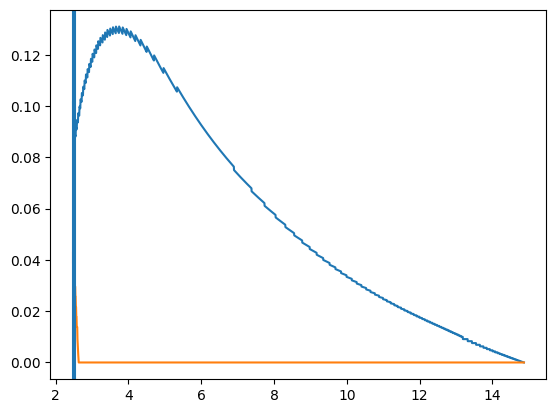

In [70]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)
plt.axvline(K_u[np.where(Kc2s<=K_u)][0])
plt.axvline(K_u[np.where(Kc2s<=K_u)][-1])

(0.0, 10.0)

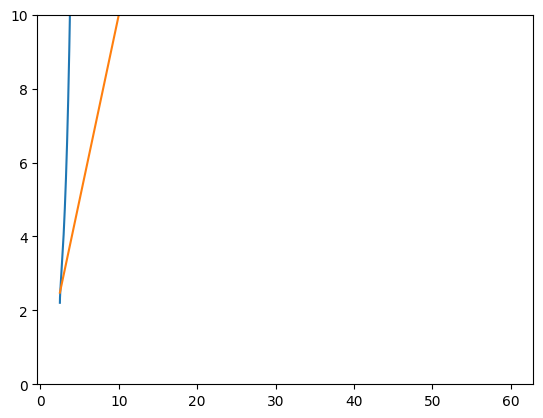

In [53]:
plt.plot(K_u, Kc2s)
plt.plot(K_u, K_u)
plt.ylim(0,10)

# visualize $\sigma$

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# 데이터 로드



In [5]:
N = 1000
df_new = pd.read_excel(f'N = {N} seed = 10 QNORMAL wo pv.xlsm',index_col=[0,1])

In [6]:
RP = df_new['r+'].unstack().to_numpy(float)
R0 = df_new['r0'].unstack().to_numpy(float)
RM = df_new['r-'].unstack().to_numpy(float)
SIG_S = df_new['sig'].unstack().to_numpy(float)

In [7]:
MCS_rp0 = np.load('mcs_rp0.npz')
Ks_d_rp0 = MCS_rp0['K_d']
Ks_u_rp0 = MCS_rp0['K_u']
ms_rp0 = MCS_rp0['ms']

MCS_rd = np.load('mcs_Rd.npz')
Ks_d_rd = MCS_rd['K_d']
Ks_u_rd = MCS_rd['K_u']
ms_rd = MCS_rd['ms']


MCS_rpl0 = np.load('mcs_rpl0.npz')
Ks_d_rpl0 = MCS_rpl0['K_d']
Ks_u_rpl0 = MCS_rpl0['K_u']
ms_rpl0 = MCS_rpl0['ms']

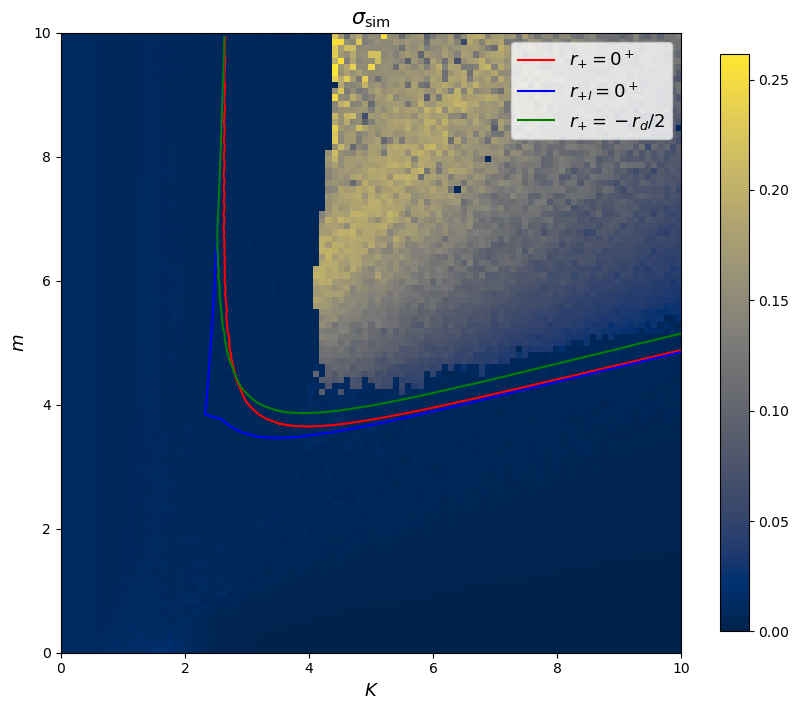

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(SIG_S.T,origin='lower',vmin=0,cmap='cividis',extent=[0, 10, 0,10],)
plt.plot(Ks_d_rp0,ms_rp0,'r-',label=r'$r_{+}=0^+$')
plt.plot(Ks_u_rp0,ms_rp0,'r-')

plt.plot(Ks_d_rpl0,ms_rpl0,'b-',label=r'$r_{+l}=0^+$')
plt.plot(Ks_u_rpl0,ms_rpl0,'b-')

plt.plot(Ks_d_rd,ms_rd,'g-',label=r'$r_{+}=-r_d/2$')
plt.plot(Ks_u_rd,ms_rd,'g-')



plt.xlim(0,10)
plt.ylim(0,10)
plt.colorbar(shrink=0.75)
plt.ylabel(r'$m$',fontsize=13)
plt.xlabel(r'$K$',fontsize=13)
plt.title(r'$\sigma_{\rm{sim}}$', fontsize=15)
plt.gca().set_aspect('equal')
plt.legend(fontsize=13)

Text(0, 0.5, '$m$')

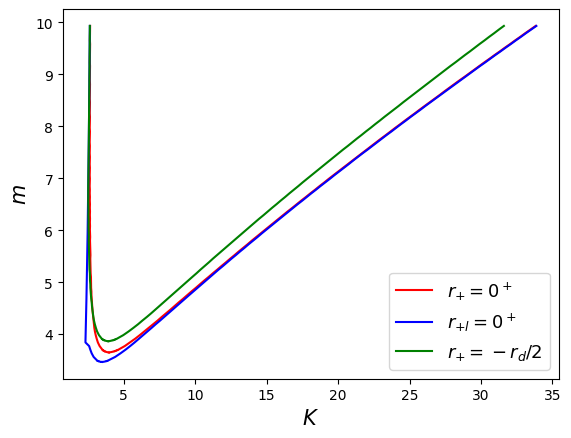

In [54]:
plt.plot(Ks_d_rp0,ms_rp0,'r-',label=r'$r_{+}=0^+$')
plt.plot(Ks_u_rp0,ms_rp0,'r-')

plt.plot(Ks_d_rpl0,ms_rpl0,'b-',label=r'$r_{+l}=0^+$')
plt.plot(Ks_u_rpl0,ms_rpl0,'b-')

plt.plot(Ks_d_rd,ms_rd,'g-',label=r'$r_{+}=-r_d/2$')
plt.plot(Ks_u_rd,ms_rd,'g-')


plt.legend(fontsize=13)
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$m$',fontsize=15)

In [665]:
K = 4
m = 6
# rs = np.linspace(0,1,10000)[1:]
Xs1 = np.logspace(-15,-3,20000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,20001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd


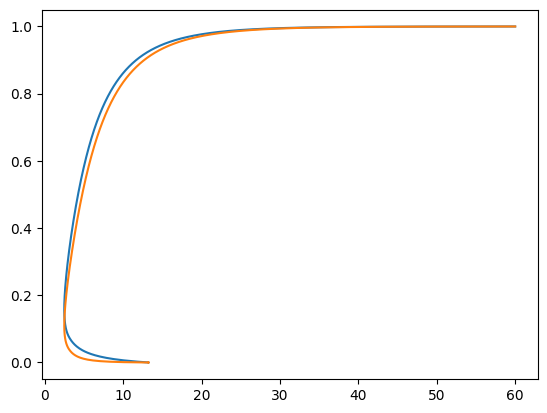

In [666]:
plt.plot(KK,R0)
plt.plot(KK,R)

In [489]:
F_OPSu = interp1d(K_u,OPS,kind='slinear')
F_r = interp1d(K_u,r_u,kind='slinear')
F_r0 = interp1d(K_u,R_0u,kind='slinear')
F_rd = interp1d(K_u,R_du,kind='slinear')

In [495]:
K = 2.48

In [496]:
r0 = F_r0(K)
R = F_r(K)
OP =  F_OPSu(K)
rs1 = np.logspace(-12,np.log10(0.01),100)
rps = np.r_[rs1,np.linspace(0.01,(1-r0)/2,100)] 

RP_ls = np.nan*rps
RP_ds = np.nan*rps

for i,rp in enumerate(rps):

    a = 1/np.sqrt(K*rp*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPs = max(b*K*rp,0)
    
    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_ls[i],err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_ds[i],err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)

RP = (RP_ls-RP_ds)
d, = np.where((RP-rps)>=0)

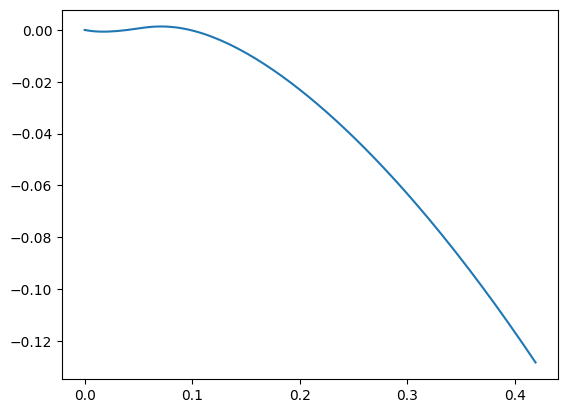

In [498]:
plt.plot(rps,RP - rps)

In [265]:
rp

0.0019630406500402682

In [263]:
delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
delta_P

0.00885255475489389

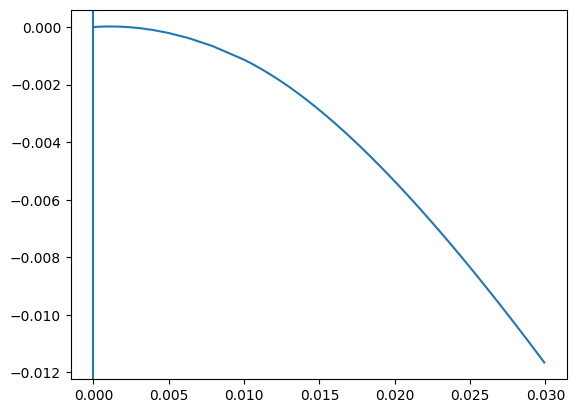

In [264]:
plt.plot(rps,RP-rps)
plt.axvline(rps[d[0]],rps[d[-1]])

In [331]:
RP1_u = []
RP1_d = []
RP01_u = []
RP01_d = []

RP_ls = []
RP_ds = []

K1p = []
for i,(X,K,r,r0,rd,OP) in enumerate(zip(Xsu,K_u,R_u,R_0u,R_du,OPS)):
    omega_pp = X

    rp =  1e-13

    a = 1/np.sqrt(K*rp*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPs = max(b*K*rp,0)
    
    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_l,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_d,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    # RP = (RP_ls-RP_ds)
    RP_ls.append(RP_l)
    RP_ds.append(RP_d)
    
RP_ls = np.array(RP_ls)
RP_ds = np.array(RP_ds)
x,=np.where(RP_ls- rp>=0)
K_drp,K_urp = K_u[x[0]],K_u[x[-1]]
K_drp,K_urp 

(2.658742556065435, 5.124797359621287)

In [330]:
K_drp,K_urp 

(2.658742556065435, 5.124797359621287)

In [293]:
RP1_u = []
RP1_d = []
RP01_u = []
RP01_d = []

RP_ls = []
RP_ds = []

K1p = []
for i,(X,K,r,r0,rd,OP) in enumerate(zip(Xsu,K_u,R_u,R_0u,R_du,OPS)):
    omega_pp = X

    rp =  -rd/2

    a = 1/np.sqrt(K*rp*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPs = max(b*K*rp,0)
    
    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) - K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_l,err = quad(integrand_Rl3, OP,OP+delta_P+OPs,args=(K*rp,OP,delta_P,m),limit=200)
    RP_d,err = quad(integrand_Rd, OP+delta_P+OPs,np.inf,args=(K*rp,0,1,m),limit=200)
    # RP = (RP_ls-RP_ds)
    RP_ls.append(RP_l)
    RP_ds.append(RP_d)
    
RP_ls = np.array(RP_ls)
RP_ds = np.array(RP_ds)
x,=np.where(RP_ls + R_du/2>=0)
K_drd,K_urd = K_u[x[0]],K_u[x[-1]]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [200]:
R_du

array([-4.78850995e-02, -4.81967567e-02, -4.85012456e-02, ...,
       -1.59886789e-05, -1.59751389e-05, -1.59616103e-05])

In [201]:
df_new.index.get_level_values(0)

Index([ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,
       ...
       10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0],
      dtype='float64', name='K', length=10201)

In [289]:
df = df_new[df_new.index.get_level_values('m') == m]

Ks = df.index.get_level_values(0).to_numpy(float)
rp_total = df['r+_total'].to_numpy(float)
r0 = df['r0'].to_numpy(float)
rm_total = df['r-_total'].to_numpy(float)
sig = df['sig'].to_numpy(float)

In [203]:
# simulation 
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
# analytical
from TO_sim.get_sec_r import get_r_Fun,get_rp

In [260]:
K = K_urp - 0.5


In [322]:
seed =6
N = 5000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
dt = 0.1
t = np.arange(0,5000,dt)
# K = 5.3
K = K_urp - 0.1
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=0*omega,p_omega=omega)

In [323]:
delta_P

8.073518818777192e-07

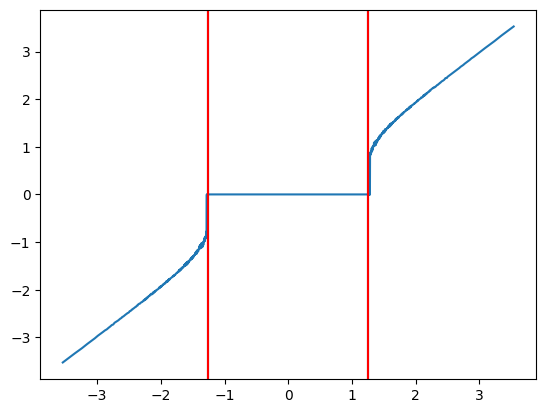

In [324]:
plt.plot(omega,(theta[-1]-theta[-1000])/(t[-1]-t[-1000]))
plt.axvline(F_OPSu(K),color='k')
plt.axvline(-F_OPSu(K),color='k')

plt.axvline(F_OPSu(K)+delta_P,color='r')
plt.axvline(-F_OPSu(K)-delta_P,color='r')
# plt.xlim(F_OPSu(K)-delta_P,F_OPSu(K)+delta_P)

In [220]:
np.std(rs[-5000:])

0.001137844401475458

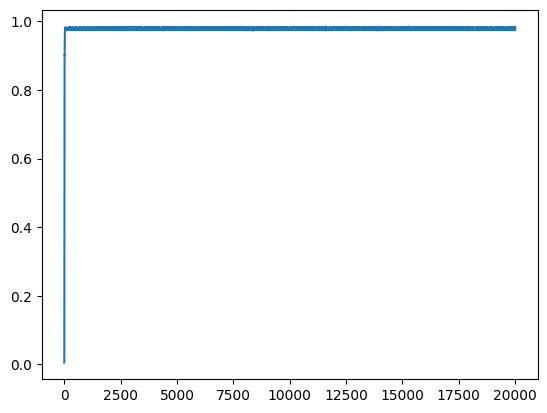

In [280]:
plt.plot(t,rs)

5.124797359621287 2.658742556065435
4.939105852510817 2.7377418667008713
0.18569150711046944 0.07899931063543608


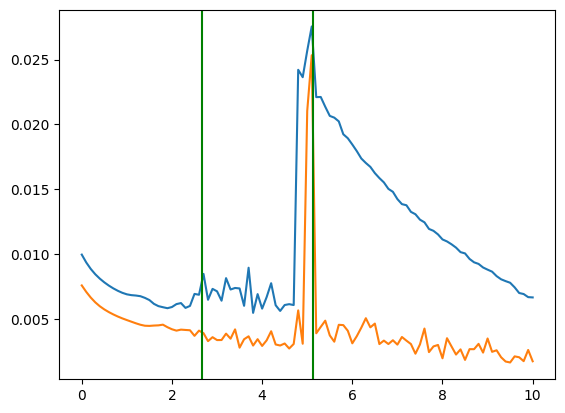

In [296]:
plt.plot(Ks,rp_total)
plt.plot(Ks,sig)
plt.axvline(K_drp,color='g')
plt.axvline(K_urp,color='g')

# plt.axvline(K_drd,color='r')
# plt.axvline(K_urd,color='r')

print(K_urp,K_drp)
print(K_urd,K_drd)
print(K_urp-K_urd,K_drd-K_drp)

In [337]:
from scipy.integrate import quad
from scipy.optimize import brentq
import numpy as np

# target value
rp = 1e-11

# 필요한 보조 함수 (예시로 넣습니다. 실제 구현에 맞게 교체)
def RP_l_of_K(K, X, r0, m, OP):
    a = 1/np.sqrt(K*rp*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = 1 if a > 1.193 else b
    OPs = max(b*K*rp,0)

    delta_P = m*K**2*r0*rp/(2*(m**2*OP**2+1)) + K**2*rp**2/(4*OP*(4*m**2*OP**2+1))
    RP_l, err = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K*rp, OP, delta_P, m), limit=200)
    return RP_l

# 함수: RP_l(K) - rp
def f(K, X, r0, m, OP):
    return RP_l_of_K(K, X, r0, m, OP) - rp

# 적절한 K 범위를 선택해야 함 (ex: 0.1 ~ 10)
K_root = brentq(f, K_u[x[0]-1], K_u[x[0]+1], args=(X, r0, m, OP))  # K1, K2는 sign 바뀌는 구간

print("Root found at K =", K_root)


NameError: name 'x' is not defined

# Get_rp

In [ ]:
def get_critical_m_all_results(m):
    import numpy as np
    from scipy.integrate import quad
    from scipy.optimize import brentq

    # 기존 코드
    Xs1 = np.logspace(-15,-3,2000)
    Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]
    R_ls = []
    R_drs = []
    for X in Xs:
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)
        omega_p = b*X
        R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        R_ls.append(R_l)
        R_drs.append(R_dr)
    R0 = np.array(R_ls)
    RD = 2*np.array(R_drs)
    R = R0 -RD
    KK = 1/(R/Xs)
    K_min_arg = np.argmin(KK)
    K_d = KK[:K_min_arg]
    K_u = KK[K_min_arg:]
    r_d = Xs[:K_min_arg]/K_d
    r_u = Xs[K_min_arg:]/K_u
    R_0d = R0[:K_min_arg]
    R_0u = R0[K_min_arg:]
    R_dd = -RD[:K_min_arg]
    R_du = -RD[K_min_arg:]
    R_u = R_0u + R_du
    R_d = R_0d + R_dd
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]
    Xsd = Xs[:K_min_arg]
    a = 1/np.sqrt(Xsu*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPS = b*Xsu
    a = 1/np.sqrt(Xsd*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPSd = b*Xsd

    # 교점 찾기 코드
    RP_d = []
    RP_u = []
    RPd_d = []
    RPd_u = []
    K1p = []
    sins = []
    num = 0
    for X, K, r, r0, rd, OP in zip(Xsu, K_u, R_u, R_0u, R_du, OPS):
        rps = np.r_[np.logspace(-12, -2, 10), np.linspace(0.01, (1 - r0) / 2, 10)]
        diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])
        sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
        if len(sign_change) == 2:
            sins.append(sign_change)
            i1 = sign_change[0]
            rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
            i2 = sign_change[-1]
            rp_right = brentq(RP_diff, rps[i2], rps[i2+1], args=(K, r0, OP, m))
            rpd_right = rpd(rp_right,K,r0,OP,m)
            rpd_left = rpd(rp_left,K,r0,OP,m)
            RP_d.append(rp_left)
            RP_u.append(rp_right)
            RPd_d.append(rpd_right)
            RPd_u.append(rpd_left)
            K1p.append(K)
            num += 1
        elif len(sign_change) == 1:
            i2 = sign_change[-1]
            rp_right = brentq(RP_diff, rps[i2], rps[i2+1], args=(K, r0, OP, m))
            rpd_right = rpd(rp_right,K,r0,OP,m)
            RP_d.append(0)
            RP_u.append(rp_right)
            RPd_d.append(0)
            RPd_u.append(rpd_right)
            K1p.append(K)
            num += 1

    return {
        'Xs': Xs, 'R0': R0, 'RD': RD, 'R': R, 'KK': KK, 'K_min_arg': K_min_arg,
        'K_d': K_d, 'K_u': K_u, 'r_d': r_d, 'r_u': r_u, 'R_0d': R_0d, 'R_0u': R_0u,
        'R_dd': R_dd, 'R_du': R_du, 'R_u': R_u, 'R_d': R_d, 'K_start': K_start,
        'Xsu': Xsu, 'Xsd': Xsd, 'OPS': OPS, 'OPSd': OPSd,
        'RP_d': RP_d, 'RP_u': RP_u, 'RPd_d': RPd_d, 'RPd_u': RPd_u, 'K1p': K1p
    }

In [427]:
m = 5
# rs = np.linspace(0,1,10000)[1:]
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd


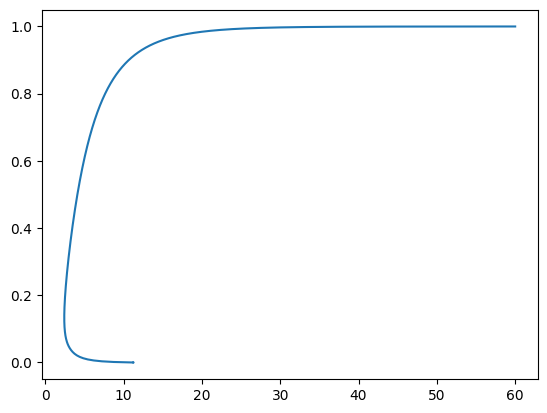

In [428]:
plt.plot(KK,R)

In [429]:
b = np.where(np.where(a>1.193,1,b)>=1,1,b)

In [430]:
RP_d = []
RP_u = []
RPd_d = []
RPd_u = []
K1p = []

# 함수 정의
def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
        OP_L =  max(OP + delta_P -OPs,OP)
        RP_l, _ = quad(integrand_Rl3, OP_L , OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=200)
        # if OP_L > OP:
        #     RP_d2, _ = quad(integrand_Rd, OP, OP_L, args=(K * rp, 0, 1, m), limit=200)
        #     RP_d += RP_d2

        return RP_l - RP_d - rp
        # return RP_l - rp
    except:
        return np.nan

def rpd(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)
        
        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) - (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
        OP_L =  max(OP + delta_P -OPs,OP)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=200)
        # if OP_L > OP:
        #     RP_d2, _ = quad(integrand_Rd, OP, OP_L, args=(K * rp, 0, 1, m), limit=200)
        #     RP_d += RP_d2
        #     print('fuck')
        return - RP_d
    except:
        return np.nan

In [431]:
RP_d = []
RP_u = []
RPd_d = []
RPd_u = []
K1p = []
sins = []
num = 0
for X, K, r, r0, rd, OP in zip(Xsu, K_u, R_u, R_0u, R_du, OPS):
    # 1. 적당한 간격으로 샘플
    rps = np.r_[np.logspace(-12, -2, 10), np.linspace(0.01, (1 - r0) / 2, 10)]
    diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])

    # 2. sign change 구간 찾기 (교점 후보)
    sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]
    if len(sign_change) == 2:
        sins.append(sign_change)
        # 첫 번째 교점
        i1 = sign_change[0]
        rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))

        # 두 번째 교점
        i2 = sign_change[-1]
        rp_right = brentq(RP_diff, rps[i2], rps[i2+1], args=(K, r0, OP, m))
        rpd_right = rpd(rp_right,K,r0,OP,m)
        rpd_left = rpd(rp_left,K,r0,OP,m)
        RP_d.append(rp_left)
        RP_u.append(rp_right)
        RPd_d.append(rpd_right)
        RPd_u.append(rpd_left)
        K1p.append(K)
        num += 1
    elif len(sign_change) == 1:
        i2 = sign_change[-1]
        rp_right = brentq(RP_diff, rps[i2], rps[i2+1], args=(K, r0, OP, m))
        rpd_right = rpd(rp_right,K,r0,OP,m)

        RP_d.append(0)
        RP_u.append(rp_right)
        RPd_d.append(0)
        RPd_u.append(rpd_right)
        K1p.append(K)
        num += 1

In [432]:
F_OPSu = interp1d(K_u,OPS,kind='slinear')
F_r = interp1d(K_u,r_u,kind='slinear')
F_r0 = interp1d(K_u,R_0u,kind='slinear')
F_rd = interp1d(K_u,R_du,kind='slinear')

In [433]:
K1p =  np.array(K1p)
r0 = F_r0(K1p)
r = F_r(K1p)
rd = F_rd(K1p)
OP = F_OPSu(K1p)
rp = np.array(RP_u)
delta_P = (m * K1p**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K1p**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))


a = 1 / np.sqrt(K1p * rp * m)
b = 4 / np.pi * a - 0.3056 * a**3

# 벡터화된 연산으로 수정
b = np.where(a > 1.193, 1, b)
b = np.minimum(b, 1)
OPs = np.maximum(b * K1p * rp, 0)


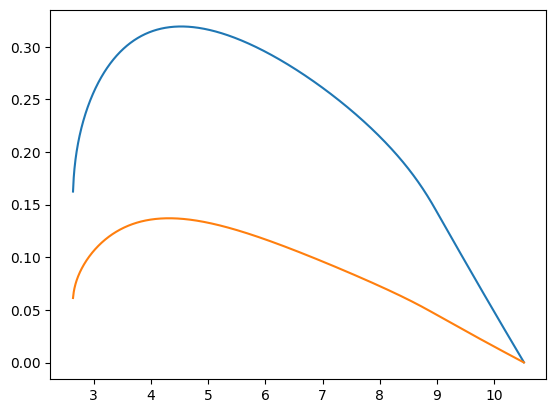

In [434]:
plt.plot(K1p,OPs)
plt.plot(K1p,delta_P)

In [410]:
K1p_rpl0 = np.array(K1p)
RP_d_rpl0 = np.array(RP_d)
RP_u_rpl0 = np.array(RP_u)
RPd_d_rpl0 = np.array(RPd_d)
RPd_u_rpl0 = np.array(RPd_u)


In [399]:
K1p_rp0 = np.array(K1p)
RP_d_rp0 = np.array(RP_d)
RP_u_rp0 = np.array(RP_u)
RPd_d_rp0 = np.array(RPd_d)
RPd_u_rp0 = np.array(RPd_u)


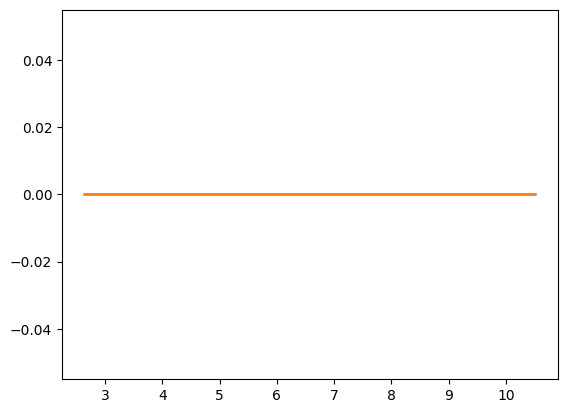

In [400]:
plt.plot(K1p_rpl0,RP_d_rpl0- RP_d_rp0)

plt.plot(K1p_rpl0,RP_u_rpl0- RP_u_rp0)

# plt.plot(K1p_rp0,RP_d_rp0)
# plt.plot(K1p_rp0,RP_u_rp0)

(0.0, 10.0)

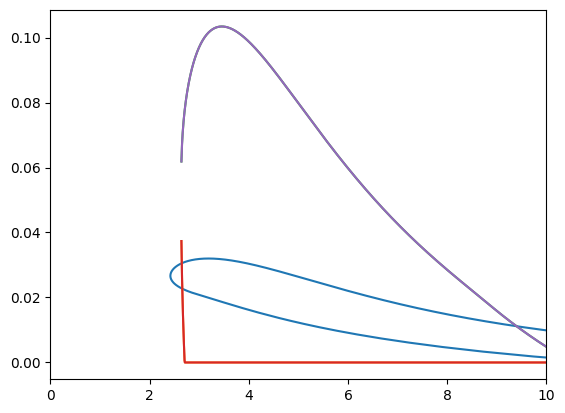

In [411]:
plt.plot(KK,RD/2)
plt.plot(K1p_rpl0,RP_d_rpl0)
plt.plot(K1p_rpl0,RP_u_rpl0)

plt.plot(K1p_rp0,RP_d_rp0)
plt.plot(K1p_rp0,RP_u_rp0)
plt.xlim(0,10)
# plt.plot(K1p,RPd_d)
# plt.plot(K1p,RPd_u)

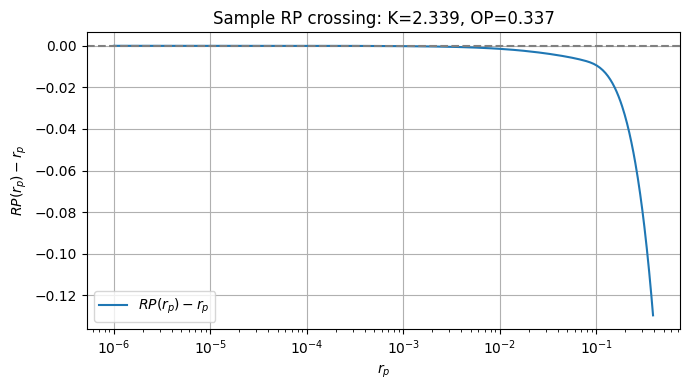

In [374]:
# 예시 파라미터 (입력으로 사용하는 하나의 K, OP, r0)
X, K, r, r0, rd, OP = Xsu[0], K_u[0], R_u[0], R_0u[0], R_du[0], OPS[0]

rps = np.r_[np.logspace(-6, -2, 100), np.linspace(0.01, (1 - r0) / 2, 100)]
diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])

# NaN이나 inf 정제
valid = np.isfinite(diffs)
rps_valid = rps[valid]
diffs_valid = diffs[valid]

plt.figure(figsize=(7, 4))
plt.plot(rps_valid, diffs_valid, label='$RP(r_p) - r_p$')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('$r_p$')
plt.ylabel('$RP(r_p) - r_p$')
plt.title(f'Sample RP crossing: K={K:.3f}, OP={OP:.3f}')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [435]:
def delta_Omega(rp,m=m,K=K,r0=r0,OP = OP):
    delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))
    return delta_P

def Omega_Pp(rp,m=m,K=K):
    OP = 4/np.pi * np.sqrt(K*rp/m) - 0.3056/np.sqrt(K*rp*(m**3))
    return OP

delta_Omega_u = []
OP_u = []

rp1 =  np.logspace(-6, -2, 100)
rps = np.r_[rp1,np.linspace(0.01, 0.3, 100)]

delta_Omega_us = np.zeros((len(rps),len(K_u)))
OP_us = np.zeros((len(rps),len(K_u)))
for i,rp_ in enumerate(rps):
    
    delta_Omega_u = []
    OP_u = []
    for K,r0,OP in zip(K_u,R_0u,OPS):
        delta_Omega_u.append(delta_Omega(rp_,m,K,r0,OP))
        OP_u.append(Omega_Pp(rp_,m,K))
    
    
    delta_Omega_us[i] = np.array(delta_Omega_u)
    OP_us[i] = np.array(OP_u)

In [403]:
rp1 =  np.logspace(-6, -2, 100)
rps = np.r_[rp1,np.linspace(0.01, 0.3, 100)]

delta_Omega_us = np.zeros((len(rps),len(K_u)))
OP_us = np.zeros((len(rps),len(K_u)))
for i,rp_ in enumerate(rps):
    
    delta_Omega_u = []
    OP_u = []
    for K,r0,OP in zip(K_u,R_0u,OPS):
        delta_Omega_u.append(delta_Omega(rp_,m,K,r0,OP))
        OP_u.append(Omega_Pp(rp_,m,K))
    
    
    delta_Omega_us[i] = np.array(delta_Omega_u)
    OP_us[i] = np.array(OP_u)

In [377]:
import numpy as np
from scipy.optimize import brentq

# ---- 이미 계산한 값 입력 ----
# K, m = 2.5, 1.0

omega = (4/np.pi)*np.sqrt(K*r/m) - 0.3056*np.sqrt(1/(K*r*m**3))

rp_do = []
rp_uo = []
K_uo = []
K_all = []
for K in K_u:
    omega = F_OPSu(K)
    r0 = F_r0(K)
    r = F_r(K)
    a = m*K**2*r0 / (2*(omega**2*m**2 + 1))
    b = K**2 / (4*omega*(4*omega**2*m**2 + 1))
    c = 4/np.pi * np.sqrt(K/m)
    d = 0.3056 / np.sqrt(K*m**3)

    F  = lambda y: b*y**4 + a*y**2 - c*y + d
    Fp = lambda y: 4*b*y**3 + 2*a*y - c

    y_max = np.sqrt(1-r0)           # 상한
    try:
        y_min = brentq(Fp, 1e-12, y_max)   # 최소 위치
        if F(y_min) < 0:                    # 부등식 성립 영역 존재
            y1 = brentq(F, 1e-12, y_min)
            y2 = brentq(F, y_min, y_max)
            # print(f"해:  {y1**2:.4e} < r+ < {y2**2:.4e}")
            rp_do.append(y1**2)
            rp_uo.append(y2**2)
            K_uo.append(K)
        else:
            print("주어진 범위에서 F(r+) < 0 인 r+ 없음")
    except ValueError:                      # 극값이 없으면
        if F(1e-12) < 0:
            print(f"0 < r+ < {(y_max**2):.4e} 전구간에서 F<0")
            K_all.append(K)
        else:
            print("주어진 범위에서 F(r+) < 0 인 r+ 없음")


주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주어진 범위에서 F(r+) < 0 인 r+ 없음
주

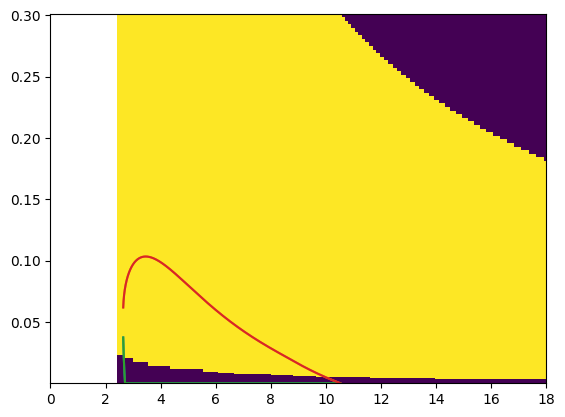

In [436]:
plt.pcolormesh(K_u,rps,(OP_us>delta_Omega_us))
plt.plot(K1p_rpl0,RP_d_rpl0)
plt.plot(K1p_rpl0,RP_u_rpl0)

plt.xlim(0,18)
plt.plot(K1p_rp0,RP_d_rp0)
plt.plot(K1p_rp0,RP_u_rp0)

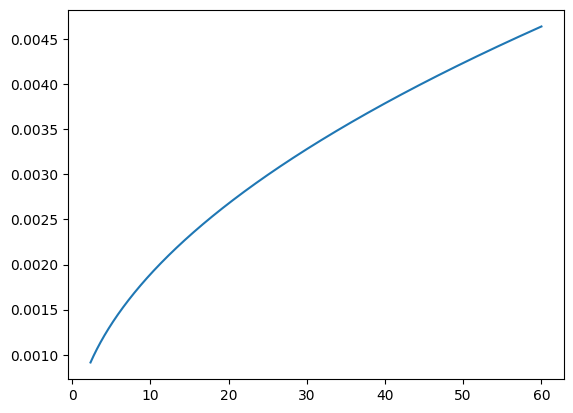

In [379]:
plt.plot(K_u,OP_us[0])

In [325]:
plt.plot(K_u,delta_Omega_u-OP_u)
K_u[np.where(delta_Omega_u-OP_u<0)]
# plt.plot(K_u,OP_u)


TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [287]:
F_OPSu = interp1d(K_u,OPS,kind='slinear')
F_r = interp1d(K_u,r_u,kind='slinear')
F_r0 = interp1d(K_u,R_0u,kind='slinear')
F_rd = interp1d(K_u,R_du,kind='slinear')

In [289]:
K_all

[]

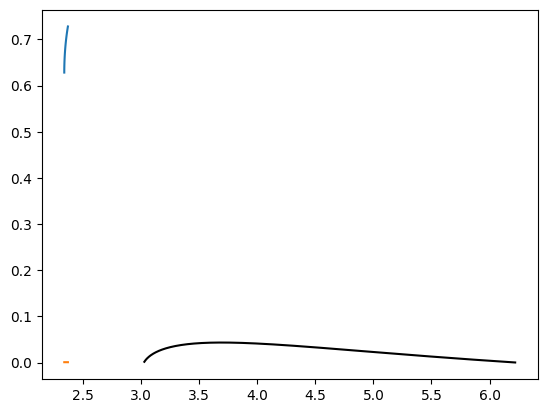

In [380]:
plt.plot(K1p_rpl0,RP_u_rpl0,color='k')
plt.plot(K_uo,rp_uo)
plt.plot(K_uo,rp_do)



# get rp

In [421]:
from sympy import *

m,K,r,r0,rd,OP,rp = symbols('m K r r0 rd \Omega_P r_+',real=True,positive=True)
op = 4/pi * sqrt(K*r/m) - 0.3056/sqrt(K*r*m**3)

delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * op**2 + 1)) + (K**2 * rp**2) / (4 * op * (4 * m**2 * op**2 + 1))

O_P = 4/pi * sqrt(K*rp/m) - 0.3056/sqrt(K*rp*m**3)



In [422]:
op

4*sqrt(K)*sqrt(r)/(pi*sqrt(m)) - 0.3056/(sqrt(K)*m**(3/2)*sqrt(r))

(-pi**3*K**(7/2)*m**(13/2)*r*r0*r_+**(3/2)*(16*K*m*r - 1.2224*pi)*(pi**2*K*m*r + 64*(K*m*r - 0.0764*pi)**2) - 2*pi**4*K**4*m**7*r**(3/2)*r_+**(5/2)*(pi**2*K*m*r + 16*(K*m*r - 0.0764*pi)**2) + 8*K*m**4*r_+*(16*K*m*r - 1.2224*pi)*(pi**2*K*m*r + 16*(K*m*r - 0.0764*pi)**2)*(pi**2*K*m*r + 64*(K*m*r - 0.0764*pi)**2) - 0.6112*pi*m**3*(16*K*m*r - 1.2224*pi)*(pi**2*K*m*r + 16*(K*m*r - 0.0764*pi)**2)*(pi**2*K*m*r + 64*(K*m*r - 0.0764*pi)**2))/(2*pi*sqrt(K)*m**(9/2)*sqrt(r_+)*(16*K*m*r - 1.2224*pi)*(pi**2*K*m*r + 16*(K*m*r - 0.0764*pi)**2)*(pi**2*K*m*r + 64*(K*m*r - 0.0764*pi)**2))

/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  func(*args, **kwar

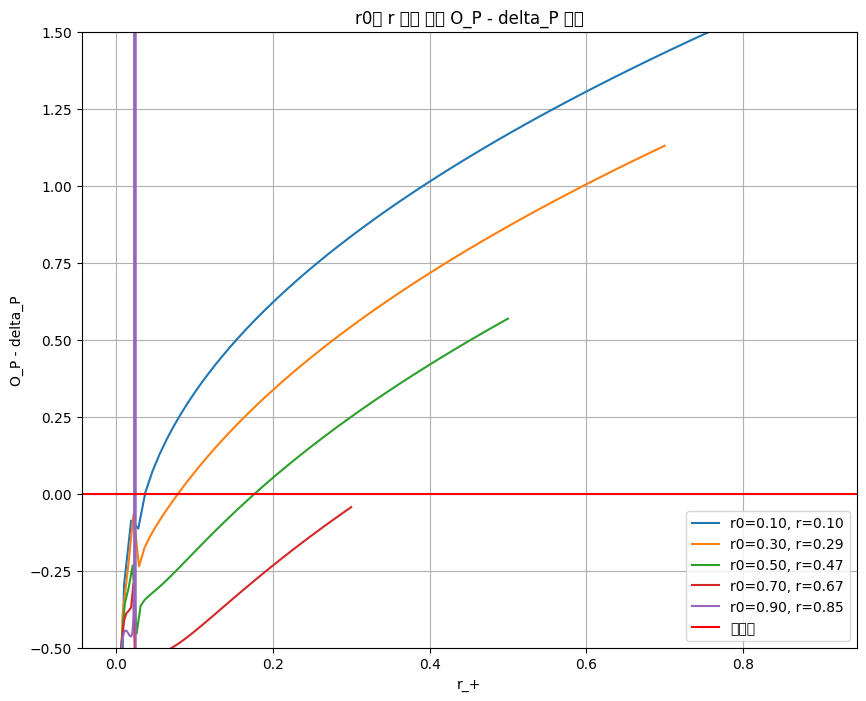

/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


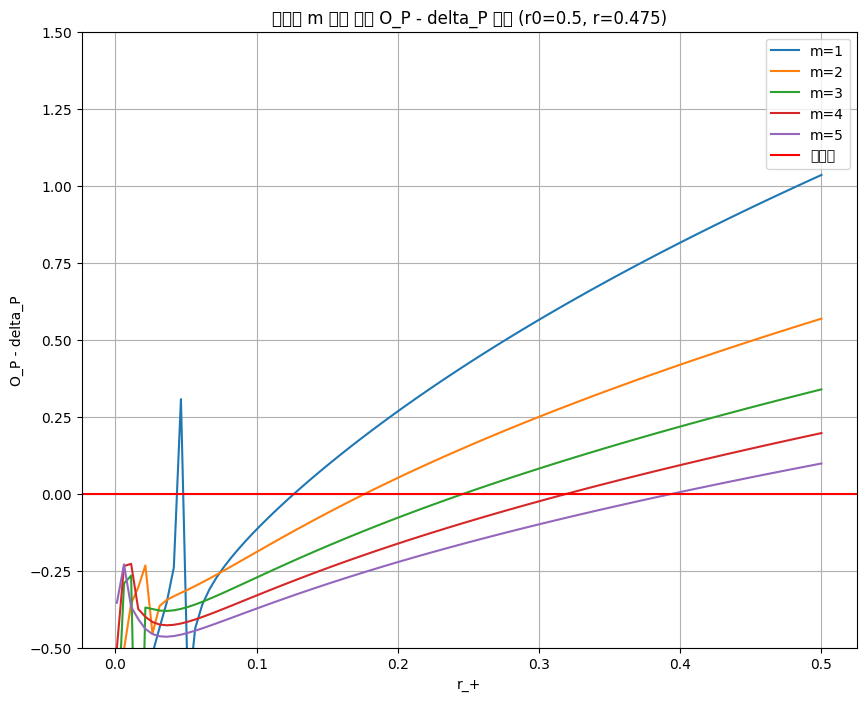

/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


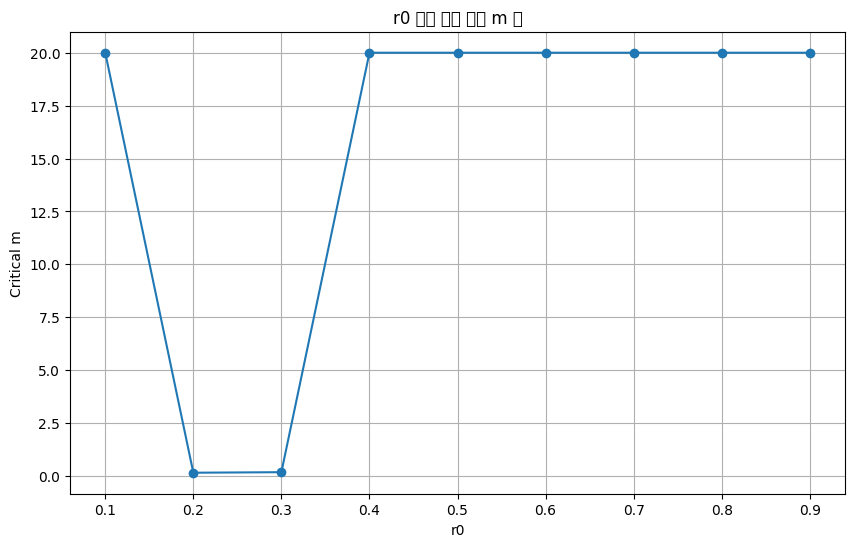

In [425]:


# r0와 r이 비슷한 값이고, r0가 r보다 살짝 더 크며, 0~1 사이의 값을 가질 때
# rp가 0~(1-r0) 범위의 값을 가질 때 O_P - delta_P > 0 조건을 만족하는지 확인

# 다양한 r0 값에 대해 테스트
r0_values = np.linspace(0.1, 0.9, 5)  # r0 값 범위
K_value = 5  # 예시 K 값
m_value = 2  # 예시 m 값

plt.figure(figsize=(10, 8))

for r0_val in r0_values:
    # r은 r0보다 살짝 작은 값
    r_val = r0_val * 0.95  # r0보다 5% 작은 값으로 설정
    
    # rp 값 범위 (0 ~ (1-r0))
    rp_values = np.linspace(0.001, 1-r0_val, 100)
    
    results = []
    for rp_val in rp_values:
        # O_P 계산
        op_val = 4/np.pi * np.sqrt(K_value*rp_val/m_value) - 0.3056/np.sqrt(K_value*rp_val*m_value**3)
        
        # delta_P 계산
        delta_p_val = (m_value * K_value**2 * r0_val * rp_val) / (2 * (m_value**2 * op_val**2 + 1)) + (K_value**2 * rp_val**2) / (4 * op_val * (4 * m_value**2 * op_val**2 + 1))
        
        # 조건 확인
        diff = op_val - delta_p_val
        results.append((rp_val, diff))
    
    # 결과 시각화
    rp_vals = [r[0] for r in results]
    diff_vals = [r[1] for r in results]
    
    plt.plot(rp_vals, diff_vals, label=f'r0={r0_val:.2f}, r={r_val:.2f}')

plt.axhline(y=0, color='r', linestyle='-', label='경계선')
plt.xlabel('r_+')
plt.ylabel('O_P - delta_P')
plt.title('r0와 r 값에 따른 O_P - delta_P 변화')
plt.legend()
plt.grid(True)
plt.ylim(-0.5, 1.5)  # y축 범위 조정

# 다양한 m 값에 대한 영향 확인
r0_val = 0.5  # 고정된 r0 값
r_val = r0_val * 0.95  # r0보다 5% 작은 값
m_values = [1, 2, 3, 4, 5]  # 다양한 m 값

plt.figure(figsize=(10, 8))

for m_val in m_values:
    rp_values = np.linspace(0.001, 1-r0_val, 100)
    results = []
    
    for rp_val in rp_values:
        op_val = 4/np.pi * np.sqrt(K_value*rp_val/m_val) - 0.3056/np.sqrt(K_value*rp_val*m_val**3)
        delta_p_val = (m_val * K_value**2 * r0_val * rp_val) / (2 * (m_val**2 * op_val**2 + 1)) + (K_value**2 * rp_val**2) / (4 * op_val * (4 * m_val**2 * op_val**2 + 1))
        diff = op_val - delta_p_val
        results.append((rp_val, diff))
    
    rp_vals = [r[0] for r in results]
    diff_vals = [r[1] for r in results]
    
    plt.plot(rp_vals, diff_vals, label=f'm={m_val}')

plt.axhline(y=0, color='r', linestyle='-', label='경계선')
plt.xlabel('r_+')
plt.ylabel('O_P - delta_P')
plt.title(f'다양한 m 값에 따른 O_P - delta_P 변화 (r0={r0_val}, r={r_val})')
plt.legend()
plt.grid(True)
plt.ylim(-0.5, 1.5)

# 임계 m 값 찾기 (O_P - delta_P = 0이 되는 지점)
def find_critical_m(K, r0, r, rp):
    def equation(m):
        op = 4/np.pi * np.sqrt(K*rp/m) - 0.3056/np.sqrt(K*rp*m**3)
        delta_p = (m * K**2 * r0 * rp) / (2 * (m**2 * op**2 + 1)) + (K**2 * rp**2) / (4 * op * (4 * m**2 * op**2 + 1))
        return op - delta_p
    
    # 이분법으로 해 찾기
    m_min, m_max = 0.1, 20
    while m_max - m_min > 1e-6:
        m_mid = (m_min + m_max) / 2
        if equation(m_mid) * equation(m_min) < 0:
            m_max = m_mid
        else:
            m_min = m_mid
    
    return m_min

# 다양한 r0, rp 값에 대한 임계 m 값 계산
r0_values = np.linspace(0.1, 0.9, 9)
critical_m_values = []

for r0_val in r0_values:
    r_val = r0_val * 0.95
    rp_val = (1 - r0_val) / 2  # rp를 가능한 범위의 중간값으로 설정
    
    try:
        critical_m = find_critical_m(K_value, r0_val, r_val, rp_val)
        critical_m_values.append((r0_val, critical_m))
    except:
        pass

if critical_m_values:
    plt.figure(figsize=(10, 6))
    plt.plot([cm[0] for cm in critical_m_values], [cm[1] for cm in critical_m_values], 'o-')
    plt.xlabel('r0')
    plt.ylabel('Critical m')
    plt.title('r0 값에 따른 임계 m 값')
    plt.grid(True)

(O_P - delta_P).simplify()

/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47480 (\N{HANGUL SYLLABLE REUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/kimgug-young/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWar

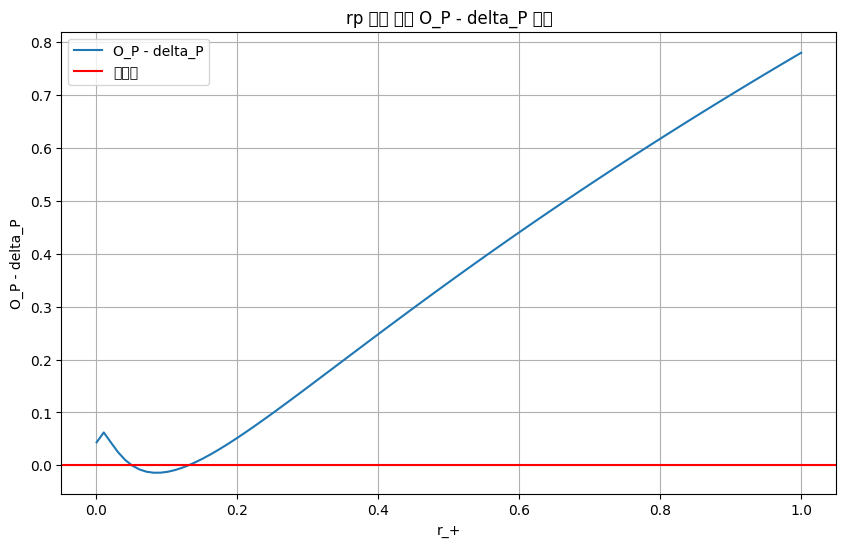

조건을 만족하는 rp 범위: 0.0010 ~ 1.0000


KeyboardInterrupt: 

In [ ]:
# rp가 0에서 1 사이의 값일 때 O_P - delta_P > 0 조건을 만족하는지 확인
rp_values = np.linspace(0.001, 1, 100)  # 0은 계산에 문제가 될 수 있으므로 0.001부터 시작
K_value = 5  # 예시 K 값
m_value = 2  # 예시 m 값
r0_value = 0.5  # 예시 r0 값

results = []
for rp_val in rp_values:
    # O_P 계산
    op_val = 4/np.pi * np.sqrt(K_value*rp_val/m_value) - 0.3056/np.sqrt(K_value*rp_val*m_value**3)
    
    # delta_P 계산
    delta_p_val = (m_value * K_value**2 * r0_value * rp_val) / (2 * (m_value**2 * op_val**2 + 1)) + (K_value**2 * rp_val**2) / (4 * op_val * (4 * m_value**2 * op_val**2 + 1))
    
    # 조건 확인
    condition_satisfied = op_val - delta_p_val > 0
    results.append((rp_val, op_val, delta_p_val, condition_satisfied))

# 결과 시각화
rp_vals = [r[0] for r in results]
condition_vals = [r[3] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(rp_vals, [r[1] - r[2] for r in results], label='O_P - delta_P')
plt.axhline(y=0, color='r', linestyle='-', label='경계선')
plt.xlabel('r_+')
plt.ylabel('O_P - delta_P')
plt.title('rp 값에 따른 O_P - delta_P 변화')
plt.legend()
plt.grid(True)
plt.show()

# 조건을 만족하는 rp 범위 출력
satisfied_rp = [rp_vals[i] for i in range(len(rp_vals)) if condition_vals[i]]
if satisfied_rp:
    print(f"조건을 만족하는 rp 범위: {min(satisfied_rp):.4f} ~ {max(satisfied_rp):.4f}")
else:
    print("조건을 만족하는 rp 값이 없습니다.")

solve(simplify(O_P - delta_P > 0),rp)